# Exploratory Data Analysis (EDA) for UK‑DALE

This notebook performs exploratory data analysis on the UK‑DALE dataset using the
original `.dat` files located under `data/raw/house_*`.

Key points:

- **Dataset:** UK Domestic Appliance-Level Electricity (UK‑DALE)
- **Source:** Imperial College London (Jack Kelly et al.)
- **Buildings:** 5 UK homes with appliance-level and whole‑home power demand
- **Sampling:**
  - Appliance channels: every 6 seconds (EcoManager / CurrentCost transmitters)
  - Whole‑home mains: every 6 seconds and, for some homes, additional 16 kHz data
- **Files used here:**
  - Time series: `data/raw/house_*/channel_*.dat` and `data/raw/house_*/mains.dat`
  - Metadata: `building1.txt`–`building5.txt`, `dataset.txt`, `meter_devices.txt`

The goal is to:

1. Load mains and selected appliance channels from `.dat` files.
2. Attach metadata (appliance types, meters, sampling periods).
3. Inspect coverage, basic statistics, and example load profiles.
4. Prepare a clear, reproducible EDA baseline for downstream modeling.


In [28]:
%pip install numpy pandas scipy tables scikit-learn matplotlib
%pip install tables

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [56]:
import os
from pathlib import Path
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yaml

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)

DATA_ROOT = Path("data") / "raw"
TIMEZONE = "Europe/London"


In [57]:
def load_yaml_like(path: Path):
    """
    Load a UK-DALE metadata file that is YAML-like (building*.txt, dataset.txt, meter_devices.txt).
    These files are valid YAML in the official repo; we assume the same structure here.
    """
    with path.open("r", encoding="utf-8") as f:
        return yaml.safe_load(f)


def load_all_building_metadata(meta_dir: Path) -> dict:
    """
    Load building1.txt ... building5.txt into a dict keyed by building index (1..5).
    """
    buildings = {}
    for i in range(1, 6):
        fname = meta_dir / f"building{i}.txt"
        if fname.exists():
            buildings[i] = load_yaml_like(fname)
        else:
            print(f"Warning: metadata file not found for building {i}: {fname}")
    return buildings


def load_dataset_metadata(meta_dir: Path) -> dict:
    dataset_file = meta_dir / "dataset.txt"
    return load_yaml_like(dataset_file) if dataset_file.exists() else {}


def load_meter_devices(meta_dir: Path) -> dict:
    meter_devices_file = meta_dir / "meter_devices.txt"
    return load_yaml_like(meter_devices_file) if meter_devices_file.exists() else {}


In [61]:
META_DIR = Path("data/raw/metadata")

building_meta = load_all_building_metadata(META_DIR)
dataset_meta = load_dataset_metadata(META_DIR)
meter_devices_meta = load_meter_devices(META_DIR)

print("Loaded building metadata for buildings:", sorted(building_meta.keys()))
print("Dataset name:", dataset_meta.get("name"))
print("Number of buildings (from metadata):", dataset_meta.get("number_of_buildings"))


Loaded building metadata for buildings: [1, 2, 3, 4, 5]
Dataset name: UK-DALE
Number of buildings (from metadata): 5


In [59]:
def load_dat_timeseries(path: Path, tz: str = TIMEZONE) -> pd.DataFrame:
    """
    Load a UK-DALE .dat file.

    According to the UKERC metadata:
    - First column: UNIX timestamp (seconds)
    - Remaining columns: power in watts (space-separated)
    Most files have a single power column.

    Returns a DataFrame with a timezone-aware DateTimeIndex (UTC) and column 'power'.
    """
    if not path.exists():
        raise FileNotFoundError(f"Data file not found: {path}")

    df = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        names=["timestamp", "power"],
        usecols=[0, 1],
        engine="c",
    )

    # Convert UNIX timestamp to datetime in local timezone, then to UTC
    dt_index = pd.to_datetime(df["timestamp"], unit="s", utc=True)
    # If you want to respect Europe/London explicitly:
    # dt_index = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize(tz).dt.tz_convert("UTC")

    df = df.drop(columns=["timestamp"])
    df.index = dt_index
    df.index.name = "time"
    return df


In [60]:
def get_elec_meters_for_building(building_index: int) -> dict:
    """
    Return the 'elec_meters' dict from building metadata for a given building.
    """
    meta = building_meta.get(building_index, {})
    return meta.get("elec_meters", {})


def get_appliances_for_building(building_index: int) -> list:
    """
    Return the list of appliances metadata for a given building.
    """
    meta = building_meta.get(building_index, {})
    return meta.get("appliances", [])


def describe_building(building_index: int):
    meta = building_meta.get(building_index, {})
    print(f"Building {building_index}")
    print("-" * 40)
    print("Type:", meta.get("building_type"))
    print("Construction year:", meta.get("construction_year"))
    print("Description of occupants:", meta.get("description_of_occupants"))
    print("Number of appliances:", len(meta.get("appliances", [])))
    print("Number of elec meters:", len(meta.get("elec_meters", {})))


In [62]:
for b in sorted(building_meta.keys()):
    describe_building(b)
    print()


Building 1
----------------------------------------
Type: end of terrace
Construction year: 1905
Description of occupants: 2 adults and 1 dog started living in the house in 2006 (i.e. before the dataset started recording).  One child born 2011-08-27 and a second child born 2014-04-27.
Number of appliances: 72
Number of elec meters: 54

Building 2
----------------------------------------
Type: end of terrace
Construction year: 1900
Description of occupants: 2 adults, 1 at work all day, other sometimes home
Number of appliances: 18
Number of elec meters: 20

Building 3
----------------------------------------
Type: None
Construction year: None
Description of occupants: None
Number of appliances: 4
Number of elec meters: 5

Building 4
----------------------------------------
Type: mid-terrace
Construction year: 1935
Description of occupants: 1 adult and 1 pensioner
Number of appliances: 11
Number of elec meters: 6

Building 5
----------------------------------------
Type: flat
Constructio

In [63]:
def resolve_data_location(building_index: int, meter_id: int) -> Path:
    """
    Given a building index and meter id, return the Path to the corresponding .dat file
    under data/raw/house_*.

    Example data_location in metadata:
      house_1/channel_1.dat
      house_2/mains.dat
    """
    elec_meters = get_elec_meters_for_building(building_index)
    meter_meta = elec_meters.get(meter_id)
    if meter_meta is None:
        raise KeyError(f"No meter {meter_id} for building {building_index}")

    rel_path = meter_meta["data_location"]  # e.g. 'house_1/channel_1.dat'
    return DATA_ROOT / rel_path


In [64]:
def find_site_meters(building_index: int):
    """
    Return a list of meter IDs that are marked as site_meter=True for a building.
    """
    elec_meters = get_elec_meters_for_building(building_index)
    site_meters = [
        mid for mid, meta in elec_meters.items() if meta.get("site_meter", False)
    ]
    return site_meters


mains_data = {}

for b in sorted(building_meta.keys()):
    site_meters = find_site_meters(b)
    if not site_meters:
        print(f"Building {b}: no site_meter found in metadata.")
        continue

    # In UK-DALE, there can be multiple site meters (e.g. whole-house Tx and sound card).
    # Here we just load the first one for EDA.
    mains_meter_id = site_meters[0]
    mains_path = resolve_data_location(b, mains_meter_id)
    print(f"Building {b}: loading mains from meter {mains_meter_id} at {mains_path}")
    mains_data[b] = load_dat_timeseries(mains_path)

for b, df in mains_data.items():
    print(f"Building {b}: mains shape = {df.shape}, time span = {df.index.min()} → {df.index.max()}")


Building 1: loading mains from meter 1 at data\raw\house_1\channel_1.dat
Building 2: loading mains from meter 1 at data\raw\house_2\channel_1.dat
Building 3: loading mains from meter 1 at data\raw\house_3\channel_1.dat
Building 4: loading mains from meter 1 at data\raw\house_4\channel_1.dat
Building 5: loading mains from meter 1 at data\raw\house_5\channel_1.dat
Building 1: mains shape = (21837636, 1), time span = 2012-11-09 22:28:15+00:00 → 2017-04-26 17:32:40+00:00
Building 2: mains shape = (2780373, 1), time span = 2013-02-17 16:17:34+00:00 → 2013-10-10 05:15:50+00:00
Building 3: mains shape = (512327, 1), time span = 2013-02-27 20:35:14+00:00 → 2013-04-08 05:14:53+00:00
Building 4: mains shape = (2186446, 1), time span = 2013-03-09 14:40:07+00:00 → 2013-10-01 05:15:07+00:00
Building 5: mains shape = (1763101, 1), time span = 2014-06-29 16:23:48+00:00 → 2014-11-13 17:52:24+00:00


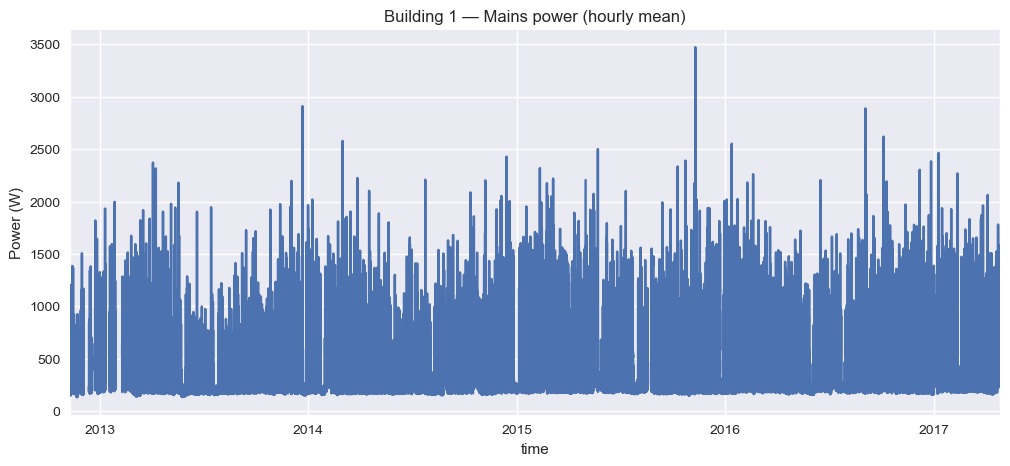

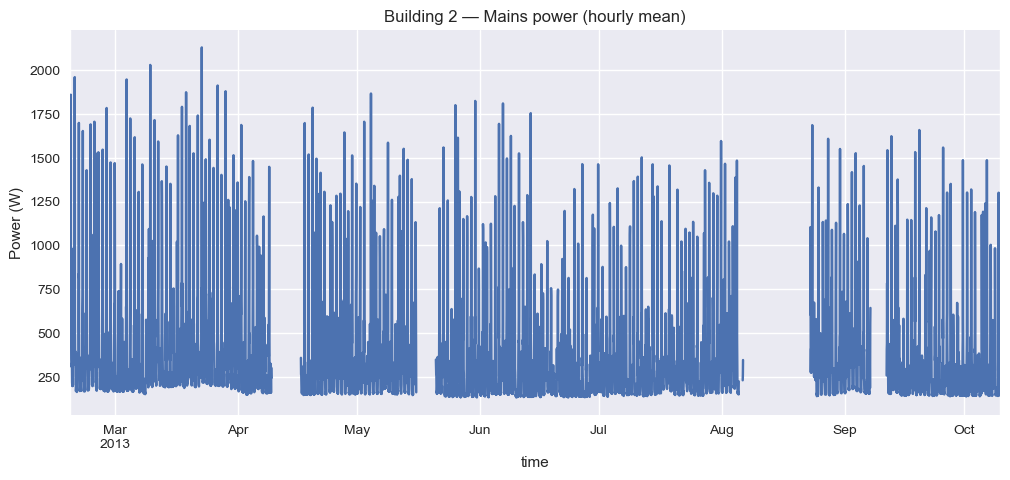

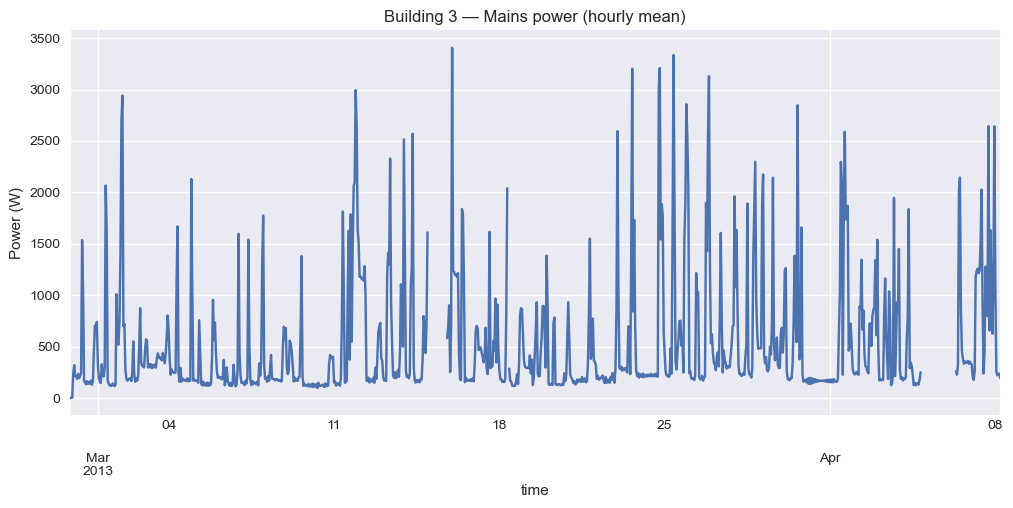

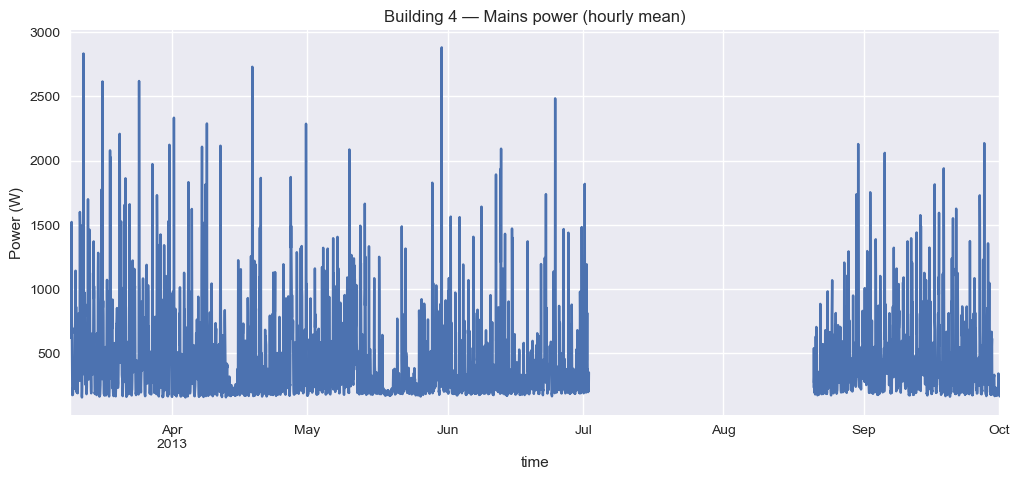

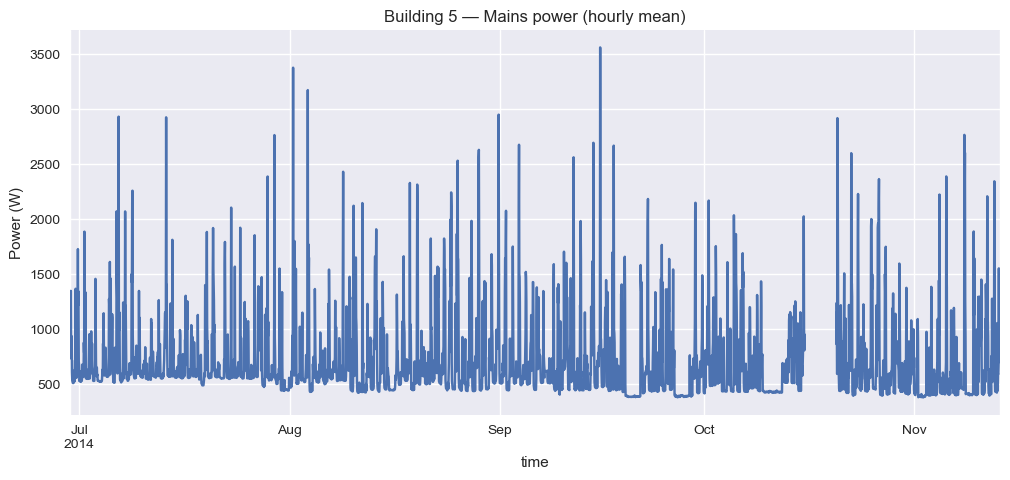

In [66]:
for b, df in mains_data.items():
    ax = df["power"].resample("1h").mean().plot()
    ax.set_title(f"Building {b} — Mains power (hourly mean)")
    ax.set_ylabel("Power (W)")
    plt.show()


In [67]:
def select_key_appliances(building_index: int, types=("kettle", "fridge", "washing machine", "washer dryer")):
    """
    Return a list of appliance metadata entries whose 'type' is in the given types.
    """
    apps = get_appliances_for_building(building_index)
    selected = [a for a in apps if a.get("type") in types]
    return selected


appliance_data = {}

for b in sorted(building_meta.keys()):
    selected_apps = select_key_appliances(b)
    if not selected_apps:
        print(f"Building {b}: no key appliances found (kettle/fridge/washing machine/washer dryer).")
        continue

    appliance_data[b] = {}
    print(f"Building {b}: loading {len(selected_apps)} key appliances")

    for app in selected_apps:
        app_type = app.get("type")
        meters = app.get("meters", [])
        if not meters:
            continue

        # For simplicity, assume one meter per appliance instance
        meter_id = meters[0]
        path = resolve_data_location(b, meter_id)
        df = load_dat_timeseries(path)
        key = f"{app_type}_m{meter_id}"
        appliance_data[b][key] = df

        print(f"  - {key}: {path}, shape={df.shape}")


Building 1: loading 3 key appliances
  - washer dryer_m5: data\raw\house_1\channel_5.dat, shape=(19555935, 1)
  - washer dryer_m5: data\raw\house_1\channel_5.dat, shape=(19555935, 1)
  - kettle_m10: data\raw\house_1\channel_10.dat, shape=(18881051, 1)
Building 2: loading 3 key appliances
  - kettle_m8: data\raw\house_2\channel_8.dat, shape=(2094523, 1)
  - washing machine_m12: data\raw\house_2\channel_12.dat, shape=(1686220, 1)
  - fridge_m14: data\raw\house_2\channel_14.dat, shape=(1687285, 1)
Building 3: loading 1 key appliances
  - kettle_m2: data\raw\house_3\channel_2.dat, shape=(515845, 1)
Building 4: loading 2 key appliances
  - kettle_m3: data\raw\house_4\channel_3.dat, shape=(2171770, 1)
  - washing machine_m6: data\raw\house_4\channel_6.dat, shape=(2180830, 1)
Building 5: loading 2 key appliances
  - kettle_m18: data\raw\house_5\channel_18.dat, shape=(985855, 1)
  - washer dryer_m24: data\raw\house_5\channel_24.dat, shape=(1859562, 1)


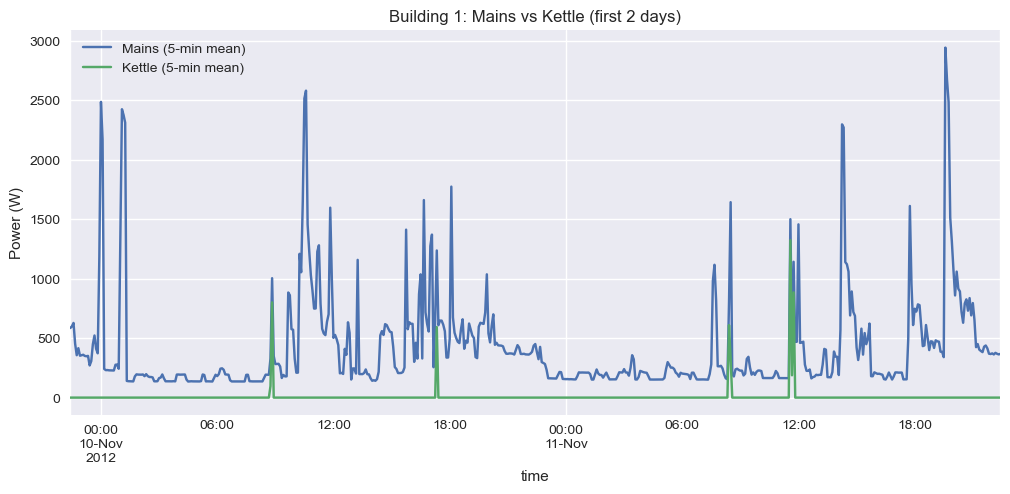

In [69]:
b = 1
if b in mains_data and b in appliance_data:
    mains = mains_data[b]["power"]
    # pick a kettle-like key if present
    kettle_key = next((k for k in appliance_data[b].keys() if "kettle" in k), None)

    if kettle_key is not None:
        kettle = appliance_data[b][kettle_key]["power"]

        # Align on a common time window
        start = max(mains.index.min(), kettle.index.min())
        end = min(mains.index.max(), kettle.index.max())
        window = slice(start, start + pd.Timedelta(days=2))  # first 2 days overlap

        fig, ax = plt.subplots()
        mains.loc[window].resample("5min").mean().plot(ax=ax, label="Mains (5-min mean)")
        kettle.loc[window].resample("5min").mean().plot(ax=ax, label="Kettle (5-min mean)")
        ax.set_title(f"Building {b}: Mains vs Kettle (first 2 days)")
        ax.set_ylabel("Power (W)")
        ax.legend()
        plt.show()
    else:
        print("No kettle-like appliance found for Building 1.")
else:
    print("Building 1 mains or appliance data not available.")


In [70]:
summary_rows = []

for b, df in mains_data.items():
    row = {
        "building": b,
        "n_samples": len(df),
        "start": df.index.min(),
        "end": df.index.max(),
        "mean_power_W": df["power"].mean(),
        "median_power_W": df["power"].median(),
        "max_power_W": df["power"].max(),
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index("building")
summary_df


,n_samples,start,end,mean_power_W,median_power_W,max_power_W
building,,,,,,
1,21837636,2012-11-09 22:28:15+00:00,2017-04-26 17:32:40+00:00,377.524379,256.0,8788
2,2780373,2013-02-17 16:17:34+00:00,2013-10-10 05:15:50+00:00,337.377566,212.0,16529
3,512327,2013-02-27 20:35:14+00:00,2013-04-08 05:14:53+00:00,506.458568,237.0,4090
4,2186446,2013-03-09 14:40:07+00:00,2013-10-01 05:15:07+00:00,428.129852,269.0,8765
5,1763101,2014-06-29 16:23:48+00:00,2014-11-13 17:52:24+00:00,690.753186,546.0,9644


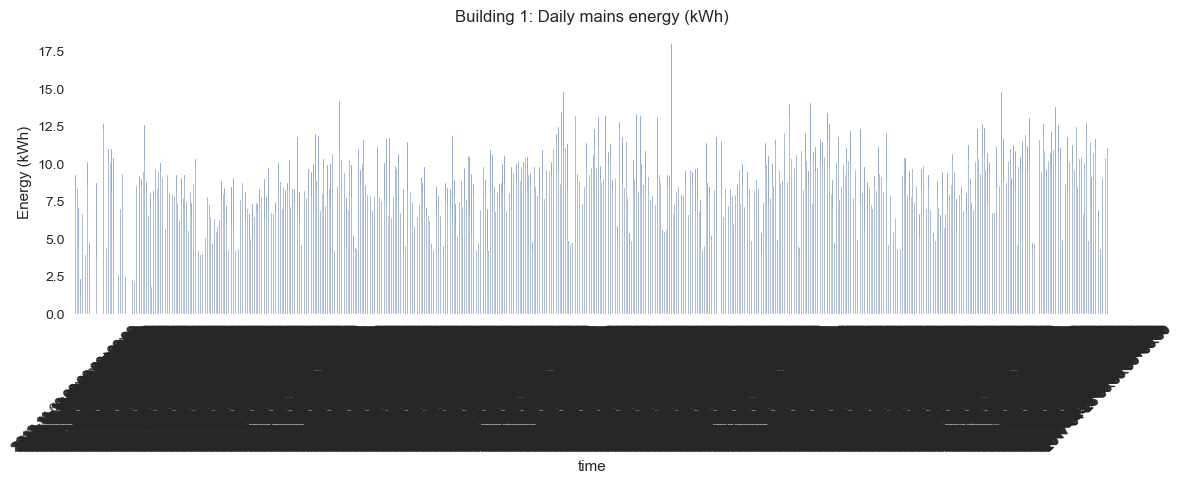

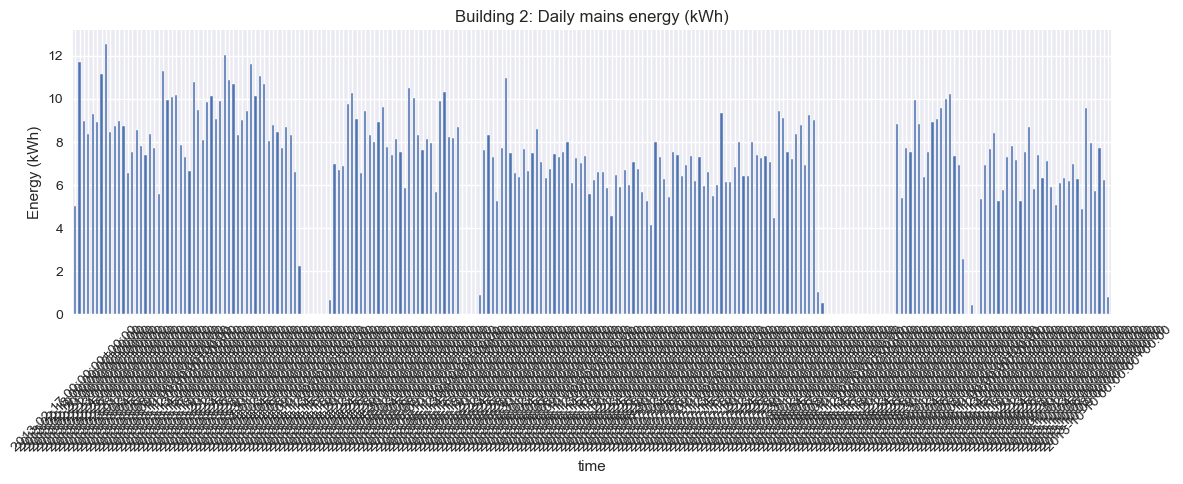

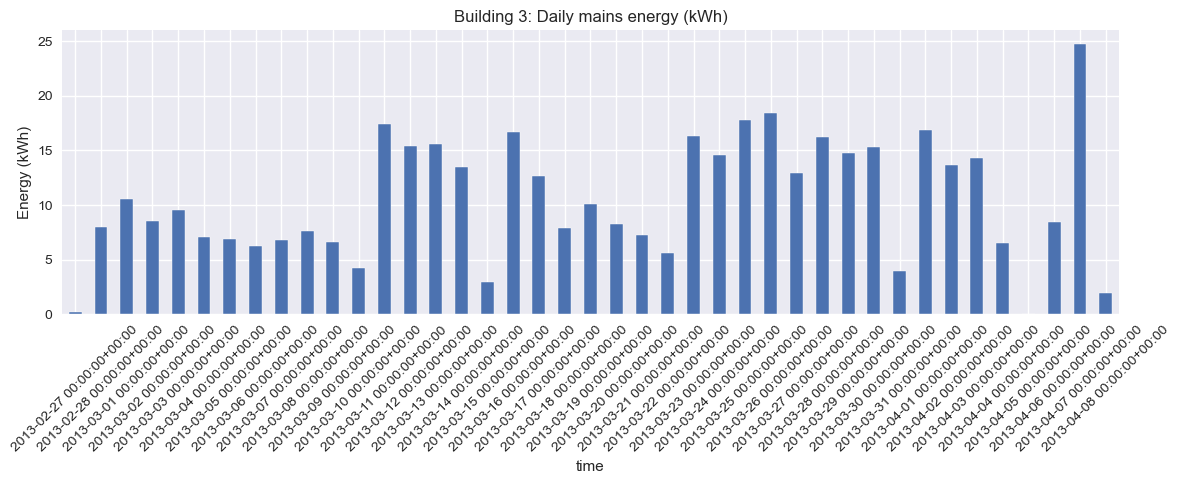

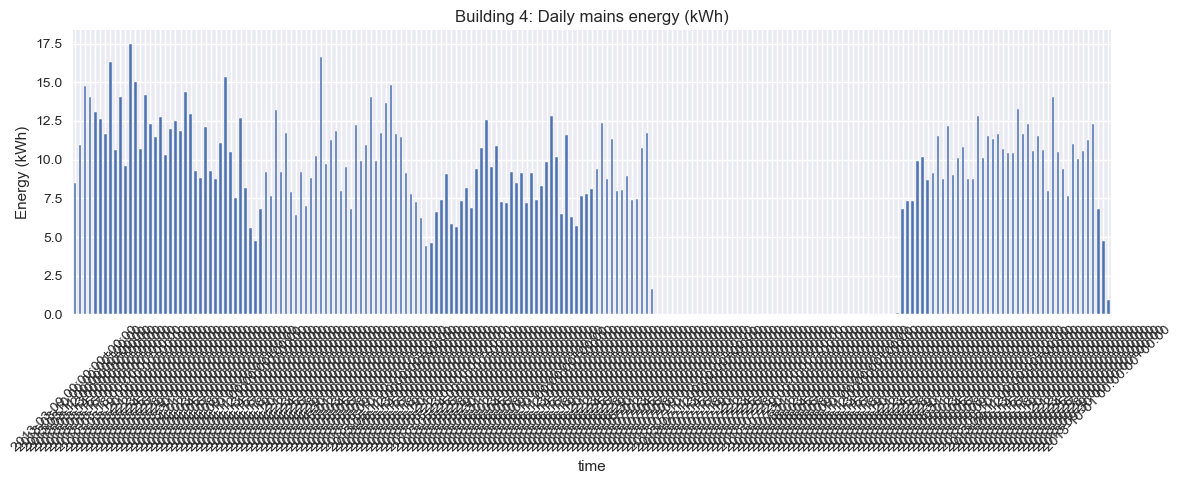

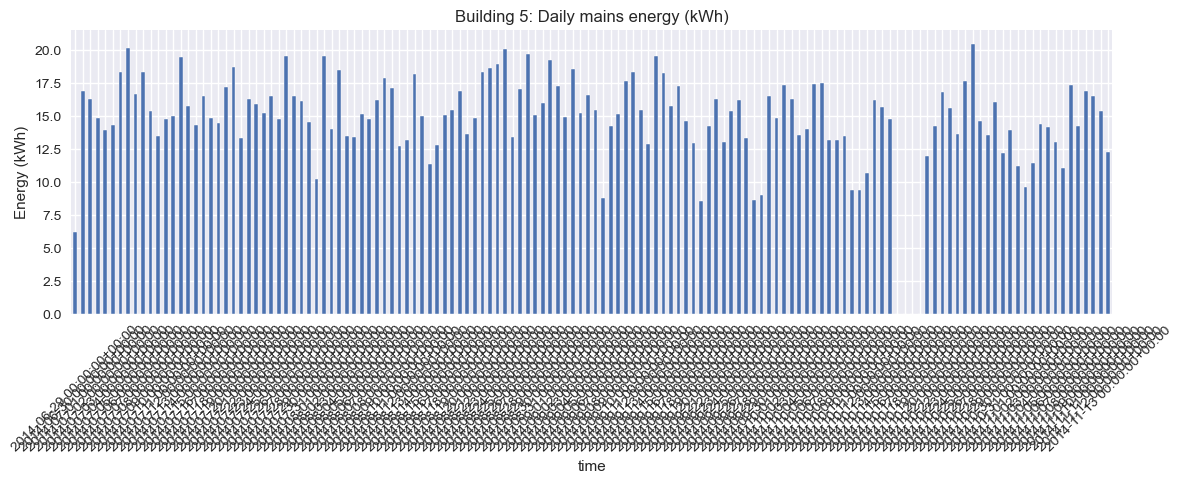

In [71]:
daily_energy = {}

for b, df in mains_data.items():
    # power in W, sample period ~6s for EcoManagerWholeHouseTx
    # energy per sample (Wh) = power_W * (sample_period_s / 3600)
    # we approximate sample_period from metadata if available
    elec_meters = get_elec_meters_for_building(b)
    site_meters = find_site_meters(b)
    sample_period = None
    if site_meters:
        device_model = elec_meters[site_meters[0]].get("device_model")
        if device_model and device_model in meter_devices_meta:
            sample_period = meter_devices_meta[device_model].get("sample_period")
    if sample_period is None:
        sample_period = 6  # default to 6 seconds

    energy_Wh = df["power"] * (sample_period / 3600.0)
    daily_kWh = energy_Wh.resample("1D").sum() / 1000.0
    daily_energy[b] = daily_kWh

    ax = daily_kWh.plot(kind="bar")
    ax.set_title(f"Building {b}: Daily mains energy (kWh)")
    ax.set_ylabel("Energy (kWh)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Summary and next steps

In this notebook we:

- Loaded **mains** and selected **appliance** channels directly from the original
  `.dat` files under `data/raw/house_*`.
- Used **building metadata** (`building1.txt`–`building5.txt`) to:
  - Identify site meters and appliance–meter mappings.
  - Attach contextual information (building type, occupants, etc.).
- Used **meter_devices metadata** to infer sampling periods where available.
- Produced:
  - Time series plots of mains power.
  - Overlays of mains vs. key appliances (e.g. kettle).
  - Basic statistics and daily energy estimates.

This EDA provides a reproducible baseline aligned with the actual UK‑DALE file
structure in this project (no CSV assumptions). From here, you can:

- Extend appliance coverage (more types, more meters).
- Implement disaggregation baselines.
- Export curated subsets for modeling (e.g. per‑appliance training windows).
